In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

### Data splitting

In [2]:
def load_and_preprocess_data(test_size=0.33, random_state=42, multiclass=False):
    iris = load_iris()
    X = pd.DataFrame(iris.data, columns=iris.feature_names)
    y = iris.target if multiclass else (iris.target == 0).astype(int)  # Use all three classes for multiway classification if multiclass=True
    
    # Add bias term to X
    X.insert(0, 'x0', 1.0)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test

### Training the model

#### Perceptron

In [3]:
class Perceptron:
    def __init__(self, learning_rate=0.01):
        self.learning_rate = learning_rate
        self.weights = None

    def fit(self, X, y):
        _, n_features = X.shape
        self.weights = np.zeros(n_features)

        epochs = 0
        while True:
            epochs += 1
            iteration_misclassifications = 0
            for idx, x_i in enumerate(X):
                linear_output = np.dot(x_i, self.weights)
                y_predicted = self._unit_step_function(linear_output)
                if y[idx] != y_predicted:
                    iteration_misclassifications += 1
                    self.weights += (x_i * (y[idx] - y_predicted))
            
            if iteration_misclassifications == 0:
                break

    def predict(self, X):
        linear_output = np.dot(X, self.weights)
        y_predicted = self._unit_step_function(linear_output)
        return y_predicted

    def _unit_step_function(self, x):
        return np.where(x >= 0, 1, 0)

#### SigmoidNeuron

In [4]:
class SigmoidNeuron:
    def __init__(self, learning_rate=0.01):
        self.learning_rate = learning_rate
        self.weights = None

    def fit(self, X, y):
        _, n_features = X.shape
        self.weights = np.zeros(n_features)

        epochs = 0
        while True:
            epochs += 1
            wNew = self.weights.copy()
            for iteration in range(X.shape[0]):
                yHat = self._sigmoid(np.dot(self.weights, X[iteration]))
                wNew += self.learning_rate * (y[iteration] - yHat) * X[iteration]
            if np.allclose(wNew, self.weights):
                break
            self.weights = wNew

    def predict(self, X):
        y_predicted = self._sigmoid(np.dot(X, self.weights))
        y_predicted_cls = np.where(y_predicted > 0.5, 1, 0)
        return y_predicted_cls
    
    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

#### SoftmaxNeuron

In [5]:
class SoftmaxedNeuron:
    def __init__(self, learning_rate=0.01, max_iter=5000, tol=1e-4):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.tol = tol
        self.weights = None

    def fit(self, X, y):
        _, n_features = X.shape
        n_classes = len(np.unique(y))
        self.weights = np.zeros((n_features, n_classes))

        y_one_hot = label_binarize(y, classes=np.unique(y))
        for _ in range(self.max_iter):
            w_for_cmp = self.weights.copy()
            y_predicted = self._softmax(np.dot(X, self.weights))
            gradient = np.dot(X.T, (y_predicted - y_one_hot))
            self.weights -= self.learning_rate * gradient
            if np.allclose(w_for_cmp, self.weights, self.tol):
                break

    def predict(self, X):
        linear_model = np.dot(X, self.weights)
        y_predicted = self._softmax(linear_model)
        return np.argmax(y_predicted, axis=1)

    def _softmax(self, x):
        exp = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp / np.sum(exp, axis=1, keepdims=True)

### Metrics

In [6]:
def calculate_metrics(y_true, y_pred, multiclass=False):
    if multiclass:
        y_true_binarized = label_binarize(y_true, classes=[0, 1, 2])
        accuracy = dict()
        precision = dict()
        recall = dict()
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(len(np.unique(y_true))):
            accuracy[i] = accuracy_score(y_true_binarized[:, i], y_pred == i)
            precision[i] = precision_score(y_true_binarized[:, i], y_pred == i, average='macro')
            recall[i] = recall_score(y_true_binarized[:, i], y_pred == i, average='macro')
            fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred == i)
            roc_auc[i] = auc(fpr[i], tpr[i])
        return accuracy, precision, recall, fpr, tpr, roc_auc
    else:
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        roc_auc = auc(fpr, tpr)
        return accuracy, precision, recall, fpr, tpr, roc_auc

def plot_roc_curve(fpr, tpr, roc_auc, multiclass=False):
    if multiclass:
        for i in range(len(fpr)):
            plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')
    else:
        plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='No skill')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

### Overfitting check and regularization

In [16]:
def check_overfitting(model, X_train, y_train, X_test, y_test, multiclass=False):
    if multiclass:
        y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])
        y_test_pred = model.predict(X_test)
        test_accuracy = []
        for i in range(len(np.unique(y_test))):
            y_pred = model.predict(X_test)
            test_accuracy.append(accuracy_score(y_test_binarized[:, i], y_pred == i))
        
        y_train_binarized = label_binarize(y_train, classes=[0, 1, 2])
        train_accuracy = []
        for i in range(len(np.unique(y_train))):
            y_pred = model.predict(X_train)
            train_accuracy.append(accuracy_score(y_train_binarized[:, i], y_pred == i))
        
        for test_acc, train_acc in zip(test_accuracy, train_accuracy):
            print(f"Train Accuracy: {train_acc}")
            print(f"Test Accuracy: {test_acc}")
            if train_accuracy > test_accuracy + 0.1:
                print("🚨 Overfitting detected 🚨")
                return True
            print("We safe. Model not overfit.")
            return False
    else:
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        train_accuracy = accuracy_score(y_train, y_train_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        print(f"Train Accuracy: {train_accuracy}")
        print(f"Test Accuracy: {test_accuracy}")

        if train_accuracy > test_accuracy + 0.1:
            print("🚨 Overfitting detected 🚨")
            return True
        print("We safe. Model not overfit.")
        return False

# class LogisticRegressionWithRegularization(LogisticRegression):
#     def __init__(self, learning_rate=0.01, n_iters=1000, reg_strength=0.01):
#         super().__init__(learning_rate, n_iters)
#         self.reg_strength = reg_strength

#     def fit(self, X, y):
#         n_samples, n_features = X.shape
#         self.weights = np.zeros(n_features)
#         self.bias = 0

#         for _ in range(self.n_iters):
#             linear_model = np.dot(X, self.weights) + self.bias
#             y_predicted = self._sigmoid(linear_model)

#             dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y)) + (self.reg_strength / n_samples) * self.weights
#             db = (1 / n_samples) * np.sum(y_predicted - y)

#             self.weights -= self.learning_rate * dw
#             self.bias -= self.learning_rate * db

Perceptron:
Accuracy: 0.98
Precision: 0.95
Recall: 1.0
AUC: 0.9838709677419355


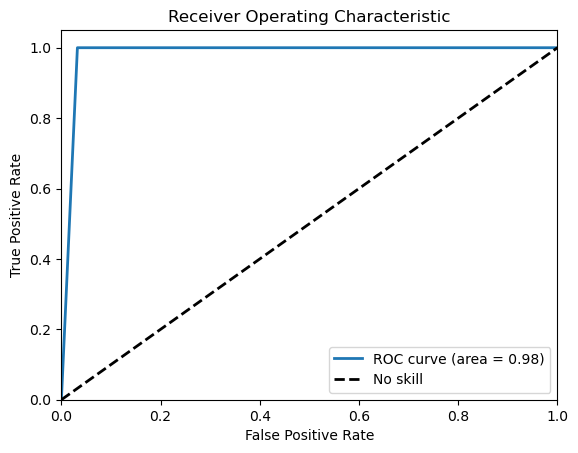

Checking for Overfitting:
Train Accuracy: 1.0
Test Accuracy: 0.98
We safe. Model not overfit.


In [17]:
# Load and split data
X_train, X_test, y_train, y_test = load_and_preprocess_data()

# Perceptron Model
perceptron = Perceptron(learning_rate=0.1)
perceptron.fit(X_train, y_train)
y_pred_perceptron = perceptron.predict(X_test)
accuracy, precision, recall, fpr, tpr, roc_auc = calculate_metrics(y_test, y_pred_perceptron)
print(f"Perceptron:\nAccuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nAUC: {roc_auc}")
plot_roc_curve(fpr, tpr, roc_auc)

## Check for overfitting in Perceptron
print("Checking for Overfitting:")
_ = check_overfitting(perceptron, X_train, y_train, X_test, y_test)

In [14]:
# Sigmoid Neuron (Logistic Regression)
sig_neu = SigmoidNeuron(learning_rate=0.1)
sig_neu.fit(X_train, y_train)
y_pred_sig_neu = sig_neu.predict(X_test)
accuracy, precision, recall, fpr, tpr, roc_auc = calculate_metrics(y_test, y_pred_sig_neu)
print(f"Sigmoid Neuron:\nAccuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nAUC: {roc_auc}")
plot_roc_curve(fpr, tpr, roc_auc)

## Check for overfitting in Logistic Regression
print("Checking for Overfitting:")
_ = check_overfitting(sig_neu, X_train, y_train, X_test, y_test)

C:\Users\TEMP.WINSERVER\AppData\Local\Temp\ipykernel_11732\2050680336.py:27: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


KeyboardInterrupt: 

Softmax Regression:
Accuracy: {0: 1.0, 1: 0.86, 2: 0.86}
Precision: {0: 1.0, 1: 0.9166666666666667, 2: 0.8478260869565217}
Recall: {0: 1.0, 1: 0.7666666666666666, 2: 0.8970588235294117}
AUC: {0: 1.0, 1: 0.7666666666666666, 2: 0.8970588235294118}


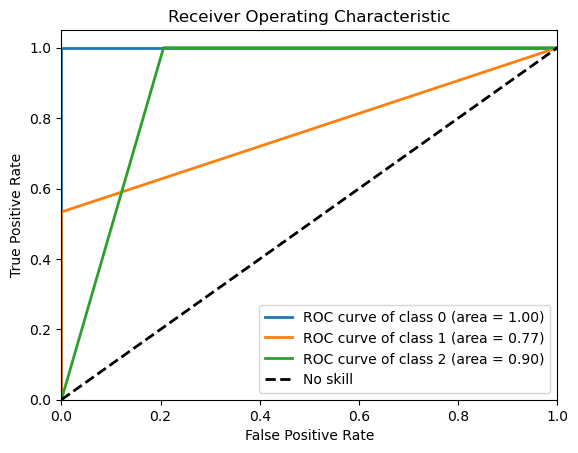

Checking for Overfitting:
Train Accuracy: 1.0
Test Accuracy: 1.0


TypeError: can only concatenate list (not "float") to list

In [18]:
# Load and split data for multi-class classification
X_train, X_test, y_train, y_test = load_and_preprocess_data(multiclass=True)

# Softmax Neuron for Multiway Classification
softmax_neu = SoftmaxedNeuron(learning_rate=0.0001, max_iter=200000)
softmax_neu.fit(X_train, y_train)
y_pred_softmax = softmax_neu.predict(X_test)
accuracy, precision, recall, fpr, tpr, roc_auc = calculate_metrics(y_test, y_pred_softmax, multiclass=True)
print(f"Softmax Regression:\nAccuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nAUC: {roc_auc}")
plot_roc_curve(fpr, tpr, roc_auc, multiclass=True)

## Check for overfitting in Softmax Regression
print("Checking for Overfitting:")
_ = check_overfitting(softmax_neu, X_train, y_train, X_test, y_test, multiclass=True)